# Deep-MINE Framework

## 1. Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score

import os
import time
import json
import random
import requests
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

RANDOM_SEED = 2025

random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 2. Loading data

### 2.1 Reviews

In [ ]:
# load json
reviews = []
with open('/content/drive/MyDrive/Mestrado/Prime_Pantry.json') as f:
    for line in f:
        reviews.append(json.loads(line))

# create dataframe
df_reviews = pd.DataFrame(reviews)
print(df_reviews.shape)
df_reviews.head()

(471614, 12)


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5.0,True,"12 14, 2014",A1NKJW0TNRVS7O,B0000DIWNZ,Tamara M.,Good clinging,Clings well,1418515200,NaN,NaN,NaN
1,4.0,True,"11 20, 2014",A2L6X37E8TFTCC,B0000DIWNZ,Amazon Customer,Fantastic buy and a good plastic wrap. Even t...,Saran could use more Plus to Cling better.,1416441600,NaN,NaN,NaN
2,4.0,True,"10 11, 2014",A2WPR4W6V48121,B0000DIWNZ,noname,ok,Four Stars,1412985600,NaN,NaN,NaN
3,3.0,False,"09 1, 2014",A27EE7X7L29UMU,B0000DIWNZ,ZapNZs,Saran Cling Plus is kind of like most of the C...,"The wrap is fantastic, but the dispensing, cut...",1409529600,4,NaN,NaN
4,4.0,True,"08 10, 2014",A1OWT4YZGB5GV9,B0000DIWNZ,Amy Rogers,This is my go to plastic wrap so there isn't m...,has been doing it's job for years,1407628800,NaN,NaN,NaN


In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471614 entries, 0 to 471613
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         471614 non-null  float64
 1   verified        471614 non-null  bool   
 2   reviewTime      471614 non-null  object 
 3   reviewerID      471614 non-null  object 
 4   asin            471614 non-null  object 
 5   reviewerName    471578 non-null  object 
 6   reviewText      471233 non-null  object 
 7   summary         471473 non-null  object 
 8   unixReviewTime  471614 non-null  int64  
 9   vote            41716 non-null   object 
 10  image           3568 non-null    object 
 11  style           6933 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 40.0+ MB


In [ ]:
# data cleaning
df_reviews = df_reviews.dropna(subset=['reviewerID', 'asin', 'reviewText'])
df_reviews = df_reviews[['reviewerID', 'asin', 'reviewText']]
print(df_reviews.shape)
df_reviews.head()

(471233, 3)


,reviewerID,asin,reviewText
0,A1NKJW0TNRVS7O,B0000DIWNZ,Good clinging
1,A2L6X37E8TFTCC,B0000DIWNZ,Fantastic buy and a good plastic wrap. Even t...
2,A2WPR4W6V48121,B0000DIWNZ,ok
3,A27EE7X7L29UMU,B0000DIWNZ,Saran Cling Plus is kind of like most of the C...
4,A1OWT4YZGB5GV9,B0000DIWNZ,This is my go to plastic wrap so there isn't m...


In [ ]:
print(f'Number of unique reviewers:', df_reviews['reviewerID'].nunique())

Number of unique reviewers: 247504


In [ ]:
print('Total number of unique products that has a review:', df_reviews['asin'].nunique())

Total number of unique products that has a review: 10814


In [ ]:
print('Total number of reviews:', df_reviews.shape[0])

Total number of reviews: 471233


In [ ]:
# check for any null value
df_reviews.isnull().sum()

,0
reviewerID,0
asin,0
reviewText,0


### 2.2 Products

In [ ]:
# load json
products = []
with open('/content/drive/MyDrive/Mestrado/meta_Prime_Pantry.json') as f:
    for line in f:
        products.append(json.loads(line))

# create dataframe
df_products = pd.DataFrame(products)
print(df_products.shape)
df_products.head(2)

(10813, 19)


,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Sink your sweet tooth into MILK DUDS Candya d...,,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",,Milk Duds,[],[],[],"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",,,$5.00,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,[],,[Sink your sweet tooth into MILK DUDS Candya d...,,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",,Milk Duds,[],[],[],"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",,,$5.00,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [ ]:
# replace empty lists with null values
df_products = df_products.map(lambda x: np.nan if len(x) == 0 else x)
df_products.head(2)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,NaN,NaN,[Sink your sweet tooth into MILK DUDS Candya d...,NaN,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",NaN,Milk Duds,NaN,NaN,NaN,"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",NaN,NaN,$5.00,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,NaN,NaN,[Sink your sweet tooth into MILK DUDS Candya d...,NaN,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",NaN,Milk Duds,NaN,NaN,NaN,"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",NaN,NaN,$5.00,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [ ]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10813 entries, 0 to 10812
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category         0 non-null      float64
 1   tech1            0 non-null      float64
 2   description      10715 non-null  object 
 3   fit              0 non-null      float64
 4   title            10813 non-null  object 
 5   also_buy         4059 non-null   object 
 6   tech2            0 non-null      float64
 7   brand            10810 non-null  object 
 8   feature          1036 non-null   object 
 9   rank             4876 non-null   object 
 10  also_view        5978 non-null   object 
 11  details          10789 non-null  object 
 12  main_cat         10813 non-null  object 
 13  similar_item     0 non-null      float64
 14  date             0 non-null      float64
 15  price            6750 non-null   object 
 16  asin             10813 non-null  object 
 17  imageURL    

In [ ]:
all_products = df_products['asin'].unique()
print('Total number of registred products:', df_products['asin'].shape[0])
print('Total number of unique products:', all_products.shape[0])

Total number of registred products: 10813
Total number of unique products: 10812


In [ ]:
# data cleaning
df_products_cleaned = df_products.dropna(subset=['description', 'asin', 'imageURL', 'imageURLHighRes'])
df_products_cleaned = df_products_cleaned[['description', 'asin', 'imageURL', 'imageURLHighRes']]
print(df_products_cleaned.shape)
df_products_cleaned.head(2)

(8942, 4)


,description,asin,imageURL,imageURLHighRes
0,[Sink your sweet tooth into MILK DUDS Candya d...,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,[Sink your sweet tooth into MILK DUDS Candya d...,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [ ]:
# check for any null value
df_products_cleaned.isnull().sum()

,0
description,0
asin,0
imageURL,0
imageURLHighRes,0


In [ ]:
print('Total number of registred products after cleaning:', df_products_cleaned['asin'].shape[0])
print('Total number of unique products after cleaning:', df_products_cleaned['asin'].unique().shape[0])

Total number of registred products after cleaning: 8942
Total number of unique products after cleaning: 8941


In [ ]:
# remove the duplicate one
df_products_cleaned = df_products_cleaned.drop_duplicates(subset=['asin'])
df_products_cleaned.shape

(8941, 4)

In [ ]:
# choose one image randomly
# df_products_cleaned['imageURL'] = df_products_cleaned['imageURL'].apply(lambda x: random.choice(x))

# choose the first image (the other images from this dataset may not be useful)
df_products_cleaned['imageURL'] = df_products_cleaned['imageURL'].apply(lambda x: x[0])

In [ ]:
# avoid urls in descriptions
df_products_cleaned['description'] = df_products_cleaned['description'].apply(lambda x: [text for text in x if 'http' not in text]).apply(lambda x: ' '.join(x))

In [ ]:
df_products_cleaned = df_products_cleaned.reset_index()

In [ ]:
df_prime_pantry = df_reviews.merge(df_products_cleaned, on='asin', how='right')  # use `right` to keep products without feedback
print(df_prime_pantry.shape)
df_prime_pantry.head()

(448467, 6)


,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
0,A2HZ0F1Q8CVX1,B00005BPJO,The outside of them is wet and sticky.. like t...,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
1,A3C4FVGQ0FSORL,B00005BPJO,They came white,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
2,A2582KMXLK2P06,B00005BPJO,"I used to hate Milk Duds for the longest time,...",Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
3,A1CSVASI7B3RTX,B00005BPJO,Very good,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
4,A2K7V3G4598QRF,B00005BPJO,I love these. The chocolate is really good and...,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...


In [ ]:
df_reviews.shape[0] - df_prime_pantry.shape[0]

22766

#### Check inconsistencies

In [ ]:
# get products that were removed after the cleaning
removed_products = list(set(all_products) - set(df_products_cleaned['asin']))
len(removed_products)

1871

In [ ]:
# count how many reviews has that removed products
df_reviews['asin'].isin(removed_products).sum()

np.int64(22706)

Still missing 60 reviews

In [ ]:
# does reviews have products that the table of products do not have?
more_products = df_reviews[~df_reviews['asin'].isin(df_products['asin'])]['asin']
more_products.nunique()

2

In [ ]:
more_products.unique()

array(['B0014CX19A', 'B0014CXT2O'], dtype=object)

In [ ]:
more_products.shape[0]

60

### 2.3 Cleaning final dataset

In [ ]:
print(df_prime_pantry.shape)
df_prime_pantry.head()

(448467, 6)


,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
0,A2HZ0F1Q8CVX1,B00005BPJO,The outside of them is wet and sticky.. like t...,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
1,A3C4FVGQ0FSORL,B00005BPJO,They came white,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
2,A2582KMXLK2P06,B00005BPJO,"I used to hate Milk Duds for the longest time,...",Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
3,A1CSVASI7B3RTX,B00005BPJO,Very good,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
4,A2K7V3G4598QRF,B00005BPJO,I love these. The chocolate is really good and...,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...


In [ ]:
print(f'Number of users:', df_prime_pantry['reviewerID'].nunique())

Number of users: 236741


In [ ]:
print(f'Number of products:', df_prime_pantry['asin'].nunique())

Number of products: 8941


<Axes: ylabel='count'>

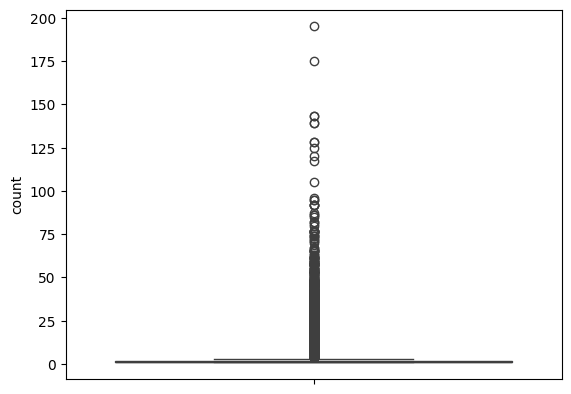

In [ ]:
sns.boxplot(df_prime_pantry['reviewerID'].value_counts())

In [ ]:
# keep only users with at least 2 feedbacks, one for training set and one for the test set
users_at_leat_two_feedbacks = df_prime_pantry['reviewerID'].value_counts()[df_prime_pantry['reviewerID'].value_counts() > 1]
df_prime_pantry = df_prime_pantry[df_prime_pantry['reviewerID'].isin(users_at_leat_two_feedbacks.index)].reset_index(drop=True).reset_index()

In [ ]:
# map null values to remove
df_prime_pantry = df_prime_pantry.replace({'None': np.nan, '': np.nan})
df_prime_pantry = df_prime_pantry.dropna()

In [ ]:
print(df_prime_pantry.shape)
df_prime_pantry.head()

(284666, 7)


,index,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
0,0,A2582KMXLK2P06,B00005BPJO,"I used to hate Milk Duds for the longest time,...",Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
1,1,A2K7V3G4598QRF,B00005BPJO,I love these. The chocolate is really good and...,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
2,2,A4GFA67FAZ5V1,B0000DIWNI,"Still infuriating to work with, and could use ...",Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
3,3,A31Y9ELLA1JUB0,B0000DIWNI,I purchased this Saran premium plastic wrap af...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...
4,4,A2EDR4BSO8F0E1,B0000DIWNI,I go through a lot of plastic ware and for me ...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,[https://images-na.ssl-images-amazon.com/image...


In [ ]:
df_prime_pantry.isnull().sum()

,0
index,0
reviewerID,0
asin,0
reviewText,0
description,0
imageURL,0
imageURLHighRes,0


In [ ]:
df_users = df_prime_pantry[['reviewerID']].drop_duplicates().reset_index(drop=True).reset_index()
df_users

,index,reviewerID
0,0,A2582KMXLK2P06
1,1,A2K7V3G4598QRF
2,2,A4GFA67FAZ5V1
3,3,A31Y9ELLA1JUB0
4,4,A2EDR4BSO8F0E1
...,...,...
72964,72964,A2YBU8RWKRMTVE
72965,72965,A2RCKT0DUJJMO6
72966,72966,A140J0CT4ULKBR
72967,72967,A1MOJO0LYCN7TA


#### Save datasets

In [ ]:
# feedbacks
df_prime_pantry.to_csv('prime_pantry.csv', index=False)

In [ ]:
# products
df_products_cleaned.to_csv('products.csv', index=False)

In [ ]:
# users
df_users.to_csv('users.csv', index=False)

In [ ]:
print(f'Number of users:', df_prime_pantry['reviewerID'].nunique())

Number of users: 72969


In [ ]:
print(f'Number of products:', df_prime_pantry['asin'].nunique())

Number of products: 8468


In [ ]:
print(f'Number of feedbacks:', df_prime_pantry.shape[0])

Number of feedbacks: 284666


Matrix -> users (72,969) x products (8,468)

Feedbacks: 284,666

### 2.4 Download images

In [ ]:
def download_image_from_url(url, path):
    try:
        img_data = requests.get(url).content
        with open(path, 'wb') as handler:
            handler.write(img_data)
    except Exception as e:
        print(f'Failed to download image {url}:', e)

In [ ]:
df_prime_pantry[['asin', 'imageURL']] \
    .drop_duplicates(subset=['asin'])['imageURL'] \
    .progress_apply(lambda x: download_image_from_url(x, f'./images/{os.path.basename(x)}'))

100%|██████████| 8468/8468 [27:21<00:00,  5.16it/s]


,imageURL
0,None
2,None
30,None
41,None
44,None
...,...
284614,None
284626,None
284647,None
284669,None


### Check number of downloaded images

In [ ]:
all_urls = df_prime_pantry.drop_duplicates(subset=['asin'])['imageURL'].apply(os.path.basename)
all_urls

,imageURL
0,51v07pI0ruL._SS40_.jpg
2,31R6Zwamy-L._SS40_.jpg
30,41NxaHjPxSL._SS40_.jpg
41,61Wz1YIacHL._SS40_.jpg
44,41XlA4a1yxL._SS40_.jpg
...,...
284614,61WLYVe8slL._SS40_.jpg
284626,61OAI2wt1KL._SS40_.jpg
284647,61F55sec3YL._SS40_.jpg
284669,61tAveMzWrL._SS40_.jpg


In [ ]:
import glob
all_downloaded_files = glob.glob('/content/images/*.jpg')
all_downloaded_files = list(map(os.path.basename, all_downloaded_files))
len(all_downloaded_files)

8176

In [ ]:
all_urls.isin(all_downloaded_files).sum()

np.int64(8468)

In [ ]:
all_urls.nunique()

8176

In [ ]:
!ls -1 /content/images | wc -l

8176


In [ ]:
# zip images
!zip -r images.zip ./images/

Streaming output truncated to the last 5000 lines.
updating: images/41-8Ip3WcTL._SS40_.jpg (deflated 6%)
updating: images/41aiWGAVvXL._SS40_.jpg (deflated 3%)
updating: images/61WP6Xkv07L._SS40_.jpg (deflated 1%)
updating: images/51f37%2BU1-8L._SS40_.jpg (deflated 3%)
updating: images/41Rut4sbIAL._SS40_.jpg (deflated 4%)
updating: images/417jPBJOSxL._SS40_.jpg (deflated 2%)
updating: images/51IbWbzPJyL._SS40_.jpg (deflated 2%)
updating: images/51JBrB2qRIL._SS40_.jpg (deflated 1%)
updating: images/51kj4OGHjrL._SS40_.jpg (deflated 3%)
updating: images/41P6nZ%2BAXuL._SS40_.jpg (deflated 10%)
updating: images/416xavBUHeL._SS40_.jpg (deflated 9%)
updating: images/3167TkwgQ3L._SS40_.jpg (deflated 12%)
updating: images/51XMVf45-TL._SS40_.jpg (deflated 2%)
updating: images/511QjKTALYL._SS40_.jpg (deflated 4%)
updating: images/41AisVM3HBL._SS40_.jpg (deflated 1%)
updating: images/41aSnBxcryL._SS40_.jpg (deflated 4%)
updating: images/41MwBqHQJfL._SS40_.jpg (deflated 4%)
updating: images/51c0yk-J

In [ ]:
from google.colab import files
files.download('/content/images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/prime_pantry.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/products.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/users.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Restore dataset

In [2]:
# download dataset feedbacks
!gdown --id 1cRC7xYuMO3KvcJtqUd5d7cchPFOb2rxc

# download dataset products
!gdown --id 1Fvd2NiO858S5rFtFbOJSysWV0ITxoiAA

# download dataset users
!gdown --id 1_79FBtpDu_32P_QzpGvlO2hU1n5nRUqs

# download images
!gdown --id 1v8GyHoaeNlT11HxePCGUtiKNYVTKXRJo

!unzip images.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/510smA03rCL._SS40_.jpg  
  inflating: images/417QgxMJdjL._SS40_.jpg  
  inflating: images/51dYe9MTxlL._SS40_.jpg  
 extracting: images/51Pds1nqrlL._SS40_.jpg  
  inflating: images/21BFiDdBW7L._SS40_.jpg  
  inflating: images/41Ntls1fpUL._SS40_.jpg  
  inflating: images/51cIijPUOpL._SS40_.jpg  
  inflating: images/51cnHV53LfL._SS40_.jpg  
  inflating: images/31Jof0H-00L._SS40_.jpg  
  inflating: images/41uJi7yRG1L._SS40_.jpg  
  inflating: images/51bwDxmIdQL._SS40_.jpg  
  inflating: images/4136BY-O5EL._SS40_.jpg  
  inflating: images/41xbCMsNlPL._SS40_.jpg  
  inflating: images/61jAQf6GgfL._SS40_.jpg  
  inflating: images/51djbi5SDxL._SS40_.jpg  
  inflating: images/41ozBLWD90L._SS40_.jpg  
  inflating: images/51EKzQJdtTL._SS40_.jpg  
  inflating: images/41g-MZZCWgL._SS40_.jpg  
  inflating: images/41aSb5a48zL._SS40_.jpg  
  inflating: images/41Xg79nND9L._SS40_.jpg  
  inflating: images/31mfV8l7BLL._SS40_.jpg  
  in

In [3]:
# feedbacks
df_prime_pantry = pd.read_csv('prime_pantry.csv')
print(df_prime_pantry.shape)
df_prime_pantry.head()

(284666, 7)


,index,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
0,0,A2582KMXLK2P06,B00005BPJO,"I used to hate Milk Duds for the longest time,...",Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
1,1,A2K7V3G4598QRF,B00005BPJO,I love these. The chocolate is really good and...,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
2,2,A4GFA67FAZ5V1,B0000DIWNI,"Still infuriating to work with, and could use ...",Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
3,3,A31Y9ELLA1JUB0,B0000DIWNI,I purchased this Saran premium plastic wrap af...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
4,4,A2EDR4BSO8F0E1,B0000DIWNI,I go through a lot of plastic ware and for me ...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...


In [4]:
# products
df_products = pd.read_csv('products.csv').reset_index()
print(df_products.shape)
df_products.head()

(8941, 5)


,index,description,asin,imageURL,imageURLHighRes
0,0,Sink your sweet tooth into MILK DUDS Candya de...,B00005BPJO,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
1,1,A perfect Lentil soup starts with Goya Lentils...,B0000DIF38,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
2,2,Saran Premium Wrap is an extra tough yet easy ...,B0000DIWNI,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
3,3,200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Easy...,B0000DIWNZ,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
4,4,"Ibarra Chocolate, 19 Oz",B0000GH6UG,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...


In [5]:
# users
df_users = pd.read_csv('users.csv')
print(df_users.shape)
df_users.head()

(72969, 2)


,index,reviewerID
0,0,A2582KMXLK2P06
1,1,A2K7V3G4598QRF
2,2,A4GFA67FAZ5V1
3,3,A31Y9ELLA1JUB0
4,4,A2EDR4BSO8F0E1


### Data splits

In [6]:
df_test = df_prime_pantry.sample(frac=1).drop_duplicates('reviewerID')
print(df_test.shape)
df_test.head()

(72969, 7)


,index,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
181350,181358,A2JLB890XPZ4V0,B00VTU1HDY,"Meh, ok, seems a bit dry, doesn't drag softly ...",The pencil gives you control and versatility. ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
273979,274010,A17PTZPTGFY7H2,B01DBCCKQK,Great if you like raspberries--I like cranberr...,Nourish your strength when you start each day ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
10113,10113,AKCF6IEQLKTJE,B000RA6GMY,I love these for the price point. I'm not upse...,"Glad Food Storage Containers, Soup and Salad, ...",https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
178744,178752,A23R9K4S5VVTQR,B00VH56D26,Really great feeling,"Specially formulated for men who want clean, h...",https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
52632,52632,A24SYEQLJT7N5R,B0014CXS8O,Nothing good about this cereal,Wake up and start your day with the simple goo...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...


In [7]:
df_train = df_prime_pantry[~df_prime_pantry['index'].isin(df_test['index'])]
print(df_train.shape)
df_train.head()

(211697, 7)


,index,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
1,1,A2K7V3G4598QRF,B00005BPJO,I love these. The chocolate is really good and...,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
2,2,A4GFA67FAZ5V1,B0000DIWNI,"Still infuriating to work with, and could use ...",Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
3,3,A31Y9ELLA1JUB0,B0000DIWNI,I purchased this Saran premium plastic wrap af...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
4,4,A2EDR4BSO8F0E1,B0000DIWNI,I go through a lot of plastic ware and for me ...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
5,5,A2FYW9VZ0AMXKY,B0000DIWNI,I am an avid cook and baker. Saran Premium Pl...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...


### Bag-of-words

https://www.kaggle.com/code/ignazio/autoencoder-for-text-in-pytorch

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download("punkt")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
class Vocabulary:

    def __init__(self):
        self.stemmer = PorterStemmer()  # stemming
        self.analyzer = CountVectorizer().build_analyzer()
        self.vectorizer = CountVectorizer(analyzer=self.stemmed_words)

    # to clean data
    def replace_special_chars(self, text):
        try:
            return re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        except:
            return None

    def normalise_text(self, text):
        text = text.str.lower()
        text = text.str.replace(r"\#","")
        text = text.str.replace(r"http\S+","URL") # \s for whitespace character and \S for non-whitespace character
        text = text.str.replace(r"@"," ")
        text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
        text = text.str.replace("\s{2,}", " ")
        text = text.apply(self.replace_special_chars)
        return text

    def preprocess(self, raw_corpus):
        corpus = self.normalise_text(raw_corpus).values.tolist()
        corpus = [x for x in corpus if not isinstance(x, float)]  # remove float nan

        # remove stop-words
        result = []
        for i in corpus:
            #out = nltk.word_tokenize(i)
            out = [x for x in i.split() if x not in stop_words]
            result.append(" ". join(out))
        return result

    def stemmed_words(self, doc):
        return (self.stemmer.stem(w) for w in self.analyzer(doc))

    def fit(self, raw_corpus):
        # preprocessing
        # corpus = self.normalise_text(raw_corpus).values.tolist()
        # corpus = [x for x in corpus if not isinstance(x, float)]  # remove float nan
        # corpus = self.preprocess(corpus)
        corpus = self.preprocess(raw_corpus)

        print('Training corpus...')
        self.vectorizer.fit(corpus)

    def transform(self, text):
        if isinstance(text, str):
            text = [text]
        x = self.vectorizer.transform(text)
        return torch.tensor(x.toarray())

    def get_vocab(self):
        vocab = self.vectorizer.get_feature_names_out()
        return vocab

    def vocab_size(self):
        return len(self.get_vocab())

In [10]:
%%time
review_vocab = Vocabulary()
review_vocab.fit(df_prime_pantry["reviewText"])
review_vocab.vocab_size()

Training corpus...
CPU times: user 1min 8s, sys: 412 ms, total: 1min 8s
Wall time: 1min 10s


29678

In [11]:
%%time
description_vocab = Vocabulary()
description_vocab.fit(df_prime_pantry["description"])
description_vocab.vocab_size()

Training corpus...
CPU times: user 8min 39s, sys: 2.64 s, total: 8min 42s
Wall time: 8min 47s


12916

In [12]:
df_train['reviewText'] = review_vocab.preprocess(df_train['reviewText'])
df_train['description'] = description_vocab.preprocess(df_train['description'])

df_test['reviewText'] = review_vocab.preprocess(df_test['reviewText'])
df_test['description'] = description_vocab.preprocess(df_test['description'])

<ipython-input-12-6bf83952d21c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['reviewText'] = review_vocab.preprocess(df_train['reviewText'])
<ipython-input-12-6bf83952d21c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['description'] = description_vocab.preprocess(df_train['description'])


In [13]:
df_train.head()

,index,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
1,1,A2K7V3G4598QRF,B00005BPJO,love chocolate really good love caramel unlike...,sink sweet tooth milk duds candya delicious bl...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
2,2,A4GFA67FAZ5V1,B0000DIWNI,still infuriating work could use better contai...,saran premium wrap extra tough yet easy handle...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
3,3,A31Y9ELLA1JUB0,B0000DIWNI,purchased saran premium plastic wrap trying re...,saran premium wrap extra tough yet easy handle...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
4,4,A2EDR4BSO8F0E1,B0000DIWNI,go lot plastic ware saran premium best,saran premium wrap extra tough yet easy handle...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
5,5,A2FYW9VZ0AMXKY,B0000DIWNI,avid cook baker saran premium plastic wrap sta...,saran premium wrap extra tough yet easy handle...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...


In [14]:
df_test.head()

,index,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
181350,181358,A2JLB890XPZ4V0,B00VTU1HDY,meh ok seems bit dry drag softly across lid ki...,pencil gives control versatility want precise ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
273979,274010,A17PTZPTGFY7H2,B01DBCCKQK,great like raspberries like cranberries recomm...,nourish strength start day special k nourish c...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
10113,10113,AKCF6IEQLKTJE,B000RA6GMY,love price point upset one left work lost serv...,glad food storage containers soup salad right ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
178744,178752,A23R9K4S5VVTQR,B00VH56D26,really great feeling,specially formulated men want clean hydrated r...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
52632,52632,A24SYEQLJT7N5R,B0014CXS8O,nothing good cereal,wake start day simple goodness kellogg crackli...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...


## 3. Deep-MINE

In [15]:
# https://discuss.pytorch.org/t/how-to-share-weights-between-two-layers/55541/2
# https://www.kaggle.com/code/ignazio/autoencoder-for-text-in-pytorch


def init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        nn.init.xavier_uniform_(module.weight)


class ImageAutoEncoder(nn.Module):

    def __init__(self, img_size=40, n_node=100, kernel_size=3, tie_weights=True):
        super().__init__()

        # encoder
        self.conv1 = nn.Conv2d(3, 64, kernel_size=kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=1, padding=1)
        self.fc3 = nn.Linear(25600, n_node, bias=True)

        # decoder
        self.fc4 = nn.Linear(n_node, 25600, bias=True)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 3, kernel_size=kernel_size, stride=1, padding=1)

        # utils
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.relu = nn.ReLU()  # TODO: change to sigmoid?
        # self.relu = nn.Sigmoid()

        # share encoder decoder weight matrices
        if tie_weights:
            self._tie_weights()

    def _tie_weights(self):
        self.fc4.weight.data = self.fc3.weight.data.transpose(0,1)
        self.conv5.weight.data = self.conv2.weight.data.transpose(0,1)
        self.conv6.weight.data = self.conv1.weight.data.transpose(0,1)

    def forward(self, x):
        # encoder
        h = self.relu(self.conv1(x))
        h = self.relu(self.conv2(h))
        h = self.pool(h)
        h = self.fc3(h.reshape(-1, 25600))

        # decoder
        h = self.fc4(h).T
        h = h.reshape(-1, 64, 20, 20)
        h = self.upsample(h)
        h = self.relu(self.conv5(h))
        x_hat = self.relu(self.conv6(h))
        return x_hat

    def encode(self, x):
        # encoder
        h = self.relu(self.conv1(x))
        h = self.relu(self.conv2(h))
        h = self.pool(h)
        h = self.fc3(h.reshape(-1, 25600))
        return h

    def decode(self, h):
        # decoder
        h = self.fc4(h).T
        h = h.reshape(-1, 64, 20, 20)
        h = self.upsample(h)
        h = self.relu(self.conv5(h))
        x_hat = self.relu(self.conv6(h))
        return x_hat


class TextAutoEncoder(nn.Module):

    def __init__(self, vocab_size, n_node=100, hidden_size=400, tie_weights=True):
        super().__init__()

        # encoder
        self.fc1 = nn.Linear(vocab_size, hidden_size, bias=True)
        self.fc2 = nn.Linear(hidden_size, n_node, bias=True)

        # decoder
        self.fc3 = nn.Linear(n_node, hidden_size, bias=True)
        self.fc4 = nn.Linear(hidden_size, vocab_size, bias=True)

        # utils
        self.relu = nn.ReLU()  # TODO: change to sigmoid?
        # self.relu = nn.Sigmoid()

        # share encoder decoder weight matrices
        if tie_weights:
            self._tie_weights()

    def _tie_weights(self):
        self.fc3.weight.data = self.fc2.weight.data.transpose(0,1)
        self.fc4.weight.data = self.fc1.weight.data.transpose(0,1)

    def forward(self, x):
        # encoder
        h = self.relu(self.fc1(x))
        h = self.fc2(h)

        # decoder
        h = self.relu(self.fc3(h))
        x_hat = self.fc4(h)
        return x_hat

    def encode(self, x):
        # encoder
        h = self.relu(self.fc1(x))
        h = self.fc2(h)
        return h

    def decode(self, h):
        # decoder
        h = self.relu(self.fc3(h))
        x_hat = self.fc4(h)
        return x_hat

In [16]:
class DeepMINEModel(nn.Module):

    def __init__(self, n_users, n_items, img_size, review_vocab_size, desc_vocab_size):
        super().__init__()

        ### parameters ###
        self.n_users  = n_users
        self.n_items = n_items

        # preference dimensions
        self.dim_u = 20
        self.dim_theta = 20

        # autoencoders dimensions
        self.dim_node = 100

        # regularization hyparameters
        self.lambda_m = 1/40
        self.lambda_d = 1/desc_vocab_size
        self.lambda_r = 1/review_vocab_size
        self.lambda_theta = 0.1
        self.lambda_beta = 0.001
        self.lambda_Wfu = 0.001

        # lambda parameters
        self.lambda_w = 1/100
        self.lambda_b = 0
        self.lambda_q = 1/400
        self.lambda_c = 0
        self.lambda_n = 1/400
        self.lambda_t = 0

        ### weights ###
        # user perception factors
        self.u_users = nn.Embedding(self.n_users, self.dim_u)
        self.theta_users = nn.Embedding(self.n_users, self.dim_theta)

        # hidden information factor
        self.v_items = nn.Embedding(self.n_items, self.dim_u)

        # cognition factors
        self.a_1 = nn.Embedding(self.n_users, 1)
        self.a_2 = nn.Embedding(self.n_users, 1)
        self.a_3 = nn.Embedding(self.n_users, 1)

        # embedding layer of information integration
        self.embeddings = nn.Embedding(self.dim_node*3, self.dim_theta)

        # biases
        self.alpha_users = nn.Embedding(self.n_users, 1)
        self.beta_items = nn.Embedding(self.n_items, 1)

        # autoencoders
        self.images_autoencoder = ImageAutoEncoder(img_size=img_size, n_node=self.dim_node)
        self.descriptions_autoencoder = TextAutoEncoder(vocab_size=desc_vocab_size, n_node=self.dim_node)
        self.reviews_autoencoder = TextAutoEncoder(vocab_size=review_vocab_size, n_node=self.dim_node)

    def prediction(self,
                   user_id: int,
                   item_id: int,
                   m3,
                   d2,
                   r2,
                   ui_latent_factor,
                   ui_content_factor,
                   vj_hidden_info,
                   ui_bias,
                   ji_bias):
        ### user's cognitive styles ###
        ai1 = self.a_1(user_id)
        ai2 = self.a_2(user_id)
        ai3 = self.a_3(user_id)

        # softmax?
        styles = F.softmax(torch.cat([ai1, ai2, ai3], dim=1), dim=1)
        ai1, ai2, ai3 = styles[:, 0].unsqueeze(-1), styles[:, 1].unsqueeze(-1), styles[:, 2].unsqueeze(-1)

        ### information integration ###
        f_c = torch.cat([ai1.T.mm(m3), ai2.T.mm(d2), ai3.T.mm(r2)], dim=-1)
        f_j = f_c.mm(self.embeddings.weight)

        # preference
        # x_ij = ui_bias + ji_bias + ui_latent_factor.mm(vj_hidden_info.T) + ui_content_factor.mm(f_j.T)
        x_ij = ui_bias + ji_bias + (ui_latent_factor * vj_hidden_info).sum(dim=1).unsqueeze(-1) + ui_content_factor.mm(f_j.T)

        return x_ij

    def information_representation(self, image, description, review):
        # latent space
        m3 = self.images_autoencoder.encode(image)
        d2 = self.descriptions_autoencoder.encode(description)
        r2 = self.reviews_autoencoder.encode(review)

        # reconstructions
        image_hat = self.images_autoencoder.decode(m3)
        description_hat = self.descriptions_autoencoder.decode(d2)
        review_hat = self.reviews_autoencoder.decode(r2)

        return {
            'embeddings': [m3, d2, r2],
            'reconstructions': [image_hat, description_hat, review_hat]
        }

    def forward(self, user_id, p_item, p_image, p_description, p_review, n_item, n_image, n_description, n_review):
        ### information representation ###
        p_representations = self.information_representation(p_image, p_description, p_review)
        n_representations = self.information_representation(n_image, n_description, n_review)

        # latent spaces
        p_m3, p_d2, p_r2 = p_representations['embeddings']
        n_m3, n_d2, n_r2 = n_representations['embeddings']

        # reconstructions
        p_image_pred, p_description_pred, p_review_pred = p_representations['reconstructions']
        n_image_pred, n_description_pred, n_review_pred = n_representations['reconstructions']

        ### calculate user preference ###
        ui_latent_factor = self.u_users(user_id)
        ui_content_factor = self.theta_users(user_id)

        # hidden information
        p_vj_hidden_info = self.v_items(p_item)
        n_vj_hidden_info = self.v_items(n_item)

        # biases
        ui_bias = self.alpha_users(user_id)
        p_ji_bias = self.beta_items(p_item)
        n_ji_bias = self.beta_items(n_item)

        ### predictions ###
        x_ij = self.prediction(user_id, p_item, p_m3, p_d2, p_r2, ui_latent_factor, ui_content_factor, p_vj_hidden_info, ui_bias, p_ji_bias)
        x_ik = self.prediction(user_id, n_item, n_m3, n_d2, n_r2, ui_latent_factor, ui_content_factor, n_vj_hidden_info, ui_bias, n_ji_bias)

        ### losses ###
        # information representation
        l1 = torch.nn.functional.mse_loss(p_image_pred, p_image)
        l2 = torch.nn.functional.mse_loss(p_description_pred, p_description)
        l3 = torch.nn.functional.mse_loss(p_review_pred, p_review)

        # preference
        outputs = (x_ij - x_ik).squeeze()
        log_likelihood = torch.nn.functional.logsigmoid(outputs.unsqueeze(0)).sum()

        loss = -log_likelihood + l1 + l2 + l3

        return loss, outputs

    def recommend(self, user_id, item_id, image, description, review):
        ### information representation ###
        representations = self.information_representation(image, description, review)

        # latent spaces
        m3, d2, r2 = representations['embeddings']

        ### calculate user preference ###
        ui_latent_factor = self.u_users(user_id)
        ui_content_factor = self.theta_users(user_id)

        # hidden information
        vj_hidden_info = self.v_items(item_id)

        # biases
        ui_bias = self.alpha_users(user_id)
        ji_bias = self.beta_items(item_id)

        ### predictions ###
        x_ij = self.prediction(user_id, item_id, m3, d2, r2, ui_latent_factor, ui_content_factor, vj_hidden_info, ui_bias, ji_bias)

        return x_ij

In [17]:
def hit_score(item_true, items_pred):
    if item_true in items_pred:
        return 1
    return 0


def evaluate(model, dataloader):
    HR = []
    AUC = []
    size = 500
    model.eval()
    for idx, data in enumerate(pbar := tqdm(dataloader, total=size)):
        user_id, positive_item, negative_item = data

        p_item, p_image, p_description, p_review = positive_item['pos_item_id'], positive_item['pos_item_image'], positive_item['pos_item_description'], positive_item['pos_item_review']
        n_item, n_image, n_description, n_review = negative_item['neg_item_id'], negative_item['neg_item_image'], negative_item['neg_item_description'], negative_item['neg_item_review']

        with torch.no_grad():
            pred_p = model.recommend(user_id.to(device), p_item.to(device), p_image.to(device), p_description.to(device), p_review.to(device))
            pred_n = model.recommend(user_id.to(device), n_item.to(device), n_image.to(device), n_description.to(device), n_review.to(device))

        predictions = torch.cat([pred_p, pred_n], dim=0).squeeze().cpu()

        # hit-ratio
        _, indices = torch.topk(predictions, k=1)
        recommends = torch.take(torch.cat([p_item, n_item], dim=0).squeeze(), indices)
        hit = hit_score(p_item, recommends)

        # roc-auc
        roc_auc = roc_auc_score(np.array([1, 0]), predictions.numpy())

        HR.append(hit)
        AUC.append(roc_auc)

        pbar.set_postfix(hit=np.mean(HR), roc_auc=np.mean(AUC))
        pbar.update()

        if idx >= size:
            break
    print('Hit-Ratio:', np.mean(HR))
    print('ROC-AUC:', np.mean(AUC))

In [31]:
def load_image(path, resize=(40, 40)):
    numpy_img = np.array(Image.open(path).resize(resize))
    if numpy_img.ndim == 2:
        numpy_img = np.repeat(numpy_img[:, :, np.newaxis], 3, axis=2)
    return torch.from_numpy(numpy_img).view(3, 40, 40) / 255


class DeepMINEDataset(Dataset):

    def __init__(self, df_feedbacks, df_products, df_users):
        self.df_feedbacks = df_feedbacks
        self.df_products = df_products
        self.df_users = df_users

    def __len__(self):
        return self.df_feedbacks.shape[0]

    def __getitem__(self, idx):
        # get user's id
        user_key = self.df_feedbacks['reviewerID'].iloc[idx]
        user_id = self.df_users[self.df_users['reviewerID'] == user_key]['index'].iloc[0]

        # get positive implicit feedback item from user
        p_item_key = self.df_feedbacks['asin'].iloc[idx]
        p_item = self.df_products[self.df_products['asin'] == p_item_key]['index'].iloc[0]

        image_name = os.path.basename(self.df_feedbacks['imageURL'].iloc[idx])
        p_image = load_image(os.path.join('./images/', image_name))

        p_description = description_vocab.transform(self.df_feedbacks['description'].iloc[idx]).squeeze(0).float()
        p_review = review_vocab.transform(self.df_feedbacks['reviewText'].iloc[idx]).squeeze(0).float()

        # get a random negative feedback item from user
        user_products = list(self.df_feedbacks.query("reviewerID == @user_key")['asin'].unique())  # list all products user has a feedback
        found_neg_item = False
        while found_neg_item is False:
            n_item_key = self.df_products.query("asin != @user_products").sample(1)['asin'].iloc[0]  # get a random negative product
            all_neg_feedbacks = self.df_feedbacks.query("asin == @n_item_key")
            if all_neg_feedbacks.shape[0] > 0:
                found_neg_item = True

        negative_product = all_neg_feedbacks.sample(1)  # get a random feedback from the random product
        n_item = self.df_products[self.df_products['asin'] == n_item_key]['index'].iloc[0]

        image_name = os.path.basename(negative_product['imageURL'].iloc[0])
        n_image = load_image(os.path.join('./images/', image_name))

        n_description = description_vocab.transform(negative_product['description']).squeeze(0).float()
        n_review = review_vocab.transform(negative_product['reviewText']).squeeze(0).float()

        positive_item = {
            'pos_item_id': p_item,
            'pos_item_image': p_image,
            'pos_item_description': p_description,
            'pos_item_review': p_review,
        }

        negative_item = {
            'neg_item_id': n_item,
            'neg_item_image': n_image,
            'neg_item_description': n_description,
            'neg_item_review': n_review,
        }

        return user_id, positive_item, negative_item


class DeepMINEDatasetTest(Dataset):

    def __init__(self, df_feedbacks, df_products, df_users):
        self.df_feedbacks = df_feedbacks
        self.df_products = df_products
        self.df_users = df_users

    def __len__(self):
        return self.df_users.shape[0]

    def __getitem__(self, idx):
        # get user's id
        user_id = self.df_users['index'].iloc[idx]
        reviewer_id = self.df_users['reviewerID'].iloc[idx]

        # get positive implicit feedback item from user
        p_item_key = self.df_feedbacks.query("reviewerID == @reviewer_id").sample(1)['asin'].iloc[0]
        p_item = self.df_products[self.df_products['asin'] == p_item_key]['index'].iloc[0]

        image_name = os.path.basename(self.df_feedbacks['imageURL'].iloc[idx])
        p_image = load_image(os.path.join('./images/', image_name))

        p_description = description_vocab.transform(self.df_feedbacks['description'].iloc[idx]).squeeze(0).float()
        p_review = review_vocab.transform(self.df_feedbacks['reviewText'].iloc[idx]).squeeze(0).float()

        # get a random negative feedback item from user
        user_products = list(self.df_feedbacks.query("reviewerID == @reviewer_id")['asin'].unique())  # list all products user has a feedback
        found_neg_item = False
        while found_neg_item is False:
            n_item_key = self.df_products.query("asin != @user_products").sample(1)['asin'].iloc[0]  # get a random negative product
            all_neg_feedbacks = self.df_feedbacks.query("asin == @n_item_key")
            if all_neg_feedbacks.shape[0] > 0:
                found_neg_item = True

        negative_product = all_neg_feedbacks.sample(1)  # get a random feedback from the random product
        display(negative_product)
        n_item = self.df_products[self.df_products['asin'] == n_item_key]['index'].iloc[0]

        image_name = os.path.basename(negative_product['imageURL'].iloc[0])
        n_image = load_image(os.path.join('./images/', image_name))

        n_description = description_vocab.transform(negative_product['description']).squeeze(0).float()
        n_review = review_vocab.transform(negative_product['reviewText']).squeeze(0).float()

        positive_item = {
            'pos_item_id': p_item,
            'pos_item_image': p_image,
            'pos_item_description': p_description,
            'pos_item_review': p_review,
        }

        negative_item = {
            'neg_item_id': n_item,
            'neg_item_image': n_image,
            'neg_item_description': n_description,
            'neg_item_review': n_review,
        }

        return user_id, positive_item, negative_item

In [19]:
n_users = df_prime_pantry['reviewerID'].nunique()
n_items = df_products['asin'].nunique()
print('Number of users:', n_users)
print('Number of items:', n_items)

Number of users: 72969
Number of items: 8941


In [20]:
model = DeepMINEModel(
    n_users=n_users,
    n_items=n_items,
    img_size=40,
    review_vocab_size=review_vocab.vocab_size(),
    desc_vocab_size=description_vocab.vocab_size(),
).to(device)
model.apply(init_weights)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))
model

Number of parameters: 42907070


DeepMINEModel(
  (u_users): Embedding(72969, 20)
  (theta_users): Embedding(72969, 20)
  (v_items): Embedding(8941, 20)
  (a_1): Embedding(72969, 1)
  (a_2): Embedding(72969, 1)
  (a_3): Embedding(72969, 1)
  (embeddings): Embedding(300, 20)
  (alpha_users): Embedding(72969, 1)
  (beta_items): Embedding(8941, 1)
  (images_autoencoder): ImageAutoEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc3): Linear(in_features=25600, out_features=100, bias=True)
    (fc4): Linear(in_features=100, out_features=25600, bias=True)
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (upsample): Upsample(scale_factor=2.0, mode='bilinear')
    (relu): ReLU()
  )
  (descriptions_autoencoder)

In [21]:
test_data = DeepMINEDatasetTest(df_train, df_products, df_users)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=0)
evaluate(model, test_dataloader)

100%|██████████| 500/500 [00:55<00:00,  9.07it/s, hit=0.523, roc_auc=0.523]

Hit-Ratio: 0.5229540918163673
ROC-AUC: 0.5229540918163673


In [22]:
training_data = DeepMINEDataset(df_train, df_products, df_users)
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True, num_workers=0)

optim_params = [
    # images
    {
        "params": [model.images_autoencoder.conv1.weight, model.images_autoencoder.conv2.weight, model.images_autoencoder.fc3.weight],
        "weight_decay": model.lambda_w,
    },
    {
        "params": [model.images_autoencoder.conv1.bias, model.images_autoencoder.conv2.bias, model.images_autoencoder.fc3.bias],
        "weight_decay": model.lambda_b,
    },
    # descriptions
    {
        "params": [model.descriptions_autoencoder.fc1.weight, model.descriptions_autoencoder.fc2.weight],
        "weight_decay": model.lambda_q,
    },
    {
        "params": [model.descriptions_autoencoder.fc1.bias, model.descriptions_autoencoder.fc2.bias],
        "weight_decay": model.lambda_c,
    },
    # reviews
    {
        "params": [model.reviews_autoencoder.fc1.weight, model.reviews_autoencoder.fc2.weight],
        "weight_decay": model.lambda_n,
    },
    {
        "params": [model.reviews_autoencoder.fc1.bias, model.reviews_autoencoder.fc2.bias],
        "weight_decay": model.lambda_t,
    },
    # user perception factors
    {
        "params": [model.u_users.weight, model.theta_users.weight],
        "weight_decay": model.lambda_theta,
    },
    # hidden information factor
    {
        "params": [model.v_items.weight],
        "weight_decay": model.lambda_theta,
    },
    # biases
    {
        "params": [model.alpha_users.weight, model.beta_items.weight],
        "weight_decay": model.lambda_beta,
    },
    # embedding layer of information integration
    {
        "params": [model.embeddings.weight],
        "weight_decay": model.lambda_Wfu,
    },
    # cognition factors
    {
        "params": [model.a_1.weight, model.a_2.weight, model.a_3.weight],
        "weight_decay": model.lambda_Wfu,
    },
]
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

loss_history = []
for epoch in range(1):
    model.train()
    running_loss = 0.0
    for idx, data in enumerate(pbar := tqdm(train_dataloader)):
        optimizer.zero_grad()
        user_id, positive_item, negative_item = data

        p_item, p_image, p_description, p_review = positive_item['pos_item_id'], positive_item['pos_item_image'], positive_item['pos_item_description'], positive_item['pos_item_review']
        n_item, n_image, n_description, n_review = negative_item['neg_item_id'], negative_item['neg_item_image'], negative_item['neg_item_description'], negative_item['neg_item_review']

        loss, outputs = model(
            user_id.to(device),
            p_item.to(device),
            p_image.to(device),
            p_description.to(device),
            p_review.to(device),
            n_item.to(device),
            n_image.to(device),
            n_description.to(device),
            n_review.to(device)
        )

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=running_loss/(idx+1))
        pbar.update()

        loss_history.append(loss.item())

 10%|█         | 1381/13232 [38:35<5:31:10,  1.68s/it, loss=10.9]


KeyboardInterrupt: 

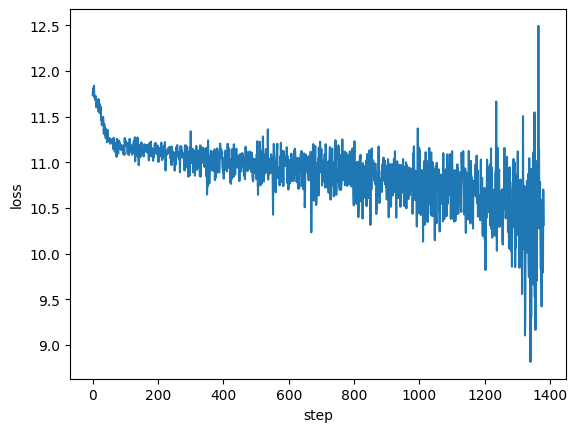

In [23]:
sns.lineplot(loss_history)
plt.xlabel('step')
plt.ylabel('loss')
plt.show()

In [24]:
evaluate(model, test_dataloader)

100%|██████████| 500/500 [00:57<00:00,  8.67it/s, hit=0.804, roc_auc=0.804]

Hit-Ratio: 0.8043912175648703
ROC-AUC: 0.8043912175648703


Perhaps check these references:

- https://github.com/sh0416/bpr/blob/master/train.py
- https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/cornac_bpr_deep_dive.ipynb
- https://medium.com/data-science/recommender-system-bayesian-personalized-ranking-from-implicit-feedback-78684bfcddf6
- https://github.com/PreferredAI/cornac/blob/93058c04a15348de60b5190bda90a82dafa9d8b6/cornac/models/vbpr/recom_vbpr.py#L249
- https://github.com/guoyang9/BPR-pytorch/tree/master
- https://ethen8181.github.io/machine-learning/recsys/4_bpr.html

**BPR: Bayesian Personalized Ranking**

![](https://seunghan96.github.io/assets/img/recsys/24-4.png)

**VBPR: Visual Bayesian Personalized Ranking**

- Paper: https://arxiv.org/pdf/1510.01784
- Github: https://github.com/aaossa/VBPR-PyTorch
- Github: https://github.com/arogers1/VBPR

![](https://raw.githubusercontent.com/aaossa/VBPR-PyTorch/main/vbpr.png?raw=True)

![](https://velog.velcdn.com/images/hyxxnii/post/732ba898-f3bb-4814-870e-0e49b7e13194/image.png)